# Fake and Real news dataset | Kaggle

## Import required libraries

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from wordcloud import WordCloud

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Loading Dataset

In [2]:
# Load the dataset (Fake.csv and True.csv must be loaded in Colab)
fake = pd.read_csv("Fake.csv")
true = pd.read_csv("True.csv")

# Set labels
fake["label"] = 1
true["label"] = 0


# Merge dataset
df = pd.concat([fake, true], ignore_index=True)

# Combine title and text
df["content"] = df["title"] + " " + df["text"]

df['label'].value_counts()

,count
label,
1,23481
0,21417


## Distribution of labels plot

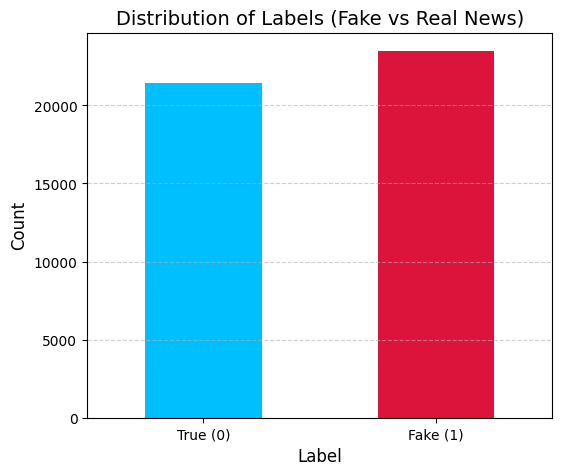

In [3]:
# Distribution of labels plot
plt.figure(figsize=(6,5))
df["label"].value_counts().reindex([0, 1]).plot(kind="bar", color=["deepskyblue", "crimson"])
plt.xticks([0, 1], ["True (0)", "Fake (1)"], rotation=0)
plt.title("Distribution of Labels (Fake vs Real News)", fontsize=14)
plt.ylabel("Count", fontsize=12)
plt.xlabel("Label", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

## Preprocessing Data

In [4]:
# Download necessary NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and numbers
    text = text.lower()  # Convert to lowercase
    tokens = text.split() # Tokenize
    tokens = [word for word in tokens if word not in stop_words] # Remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens] # Lemmatize
    tokens = [word for word in tokens if len(word) > 3]  # Filter word <= 3 characters
    return ' '.join(tokens) # Join tokens back

df['content'] = df['content'].apply(preprocess_text)
df.head()

,title,text,subject,date,label,content
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1,donald trump sends embarrassing year message d...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1,drunk bragging trump staffer started russian c...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1,sheriff david clarke becomes internet joke thr...
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1,trump obsessed even obamas name coded website ...
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1,pope francis called donald trump christmas spe...


## Split into train/test the dataset

In [5]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    df["content"], df["label"], test_size=0.2, random_state=42
)

In [6]:
label_colors = {0: 'crimson', 1: 'steelblue'}
label_names = {0: 'Fake', 1: 'Real'}

## Fake News word cloud

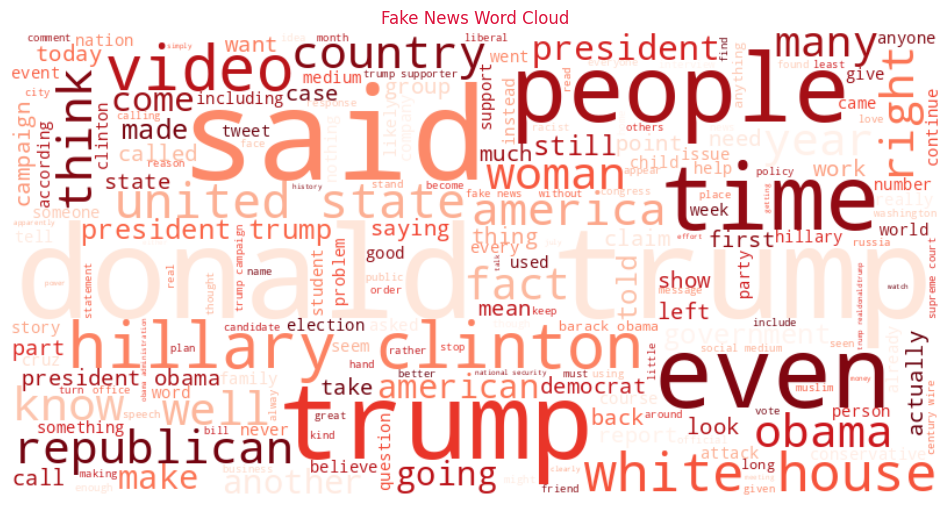

In [7]:
# Visualize fake news words
fake_words = ' '.join(df[df['label']==1]['content'].dropna().astype(str).tolist())
wordcloud_fake = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(fake_words)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis('off')
plt.title('Fake News Word Cloud', color=label_colors[0])
plt.show()

## Real News word cloud

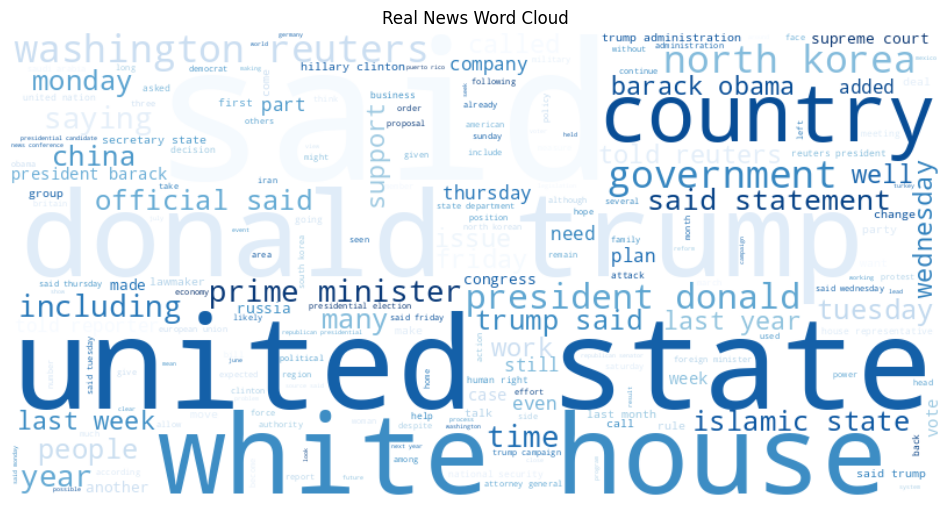

In [8]:
# Visualize real news words
real_words = ' '.join(df[df['label']==0]['content'].dropna().astype(str).tolist())
wordcloud_real = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate(real_words)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.axis('off')
plt.title('Real News Word Cloud')
plt.show()

## Top subjects plot

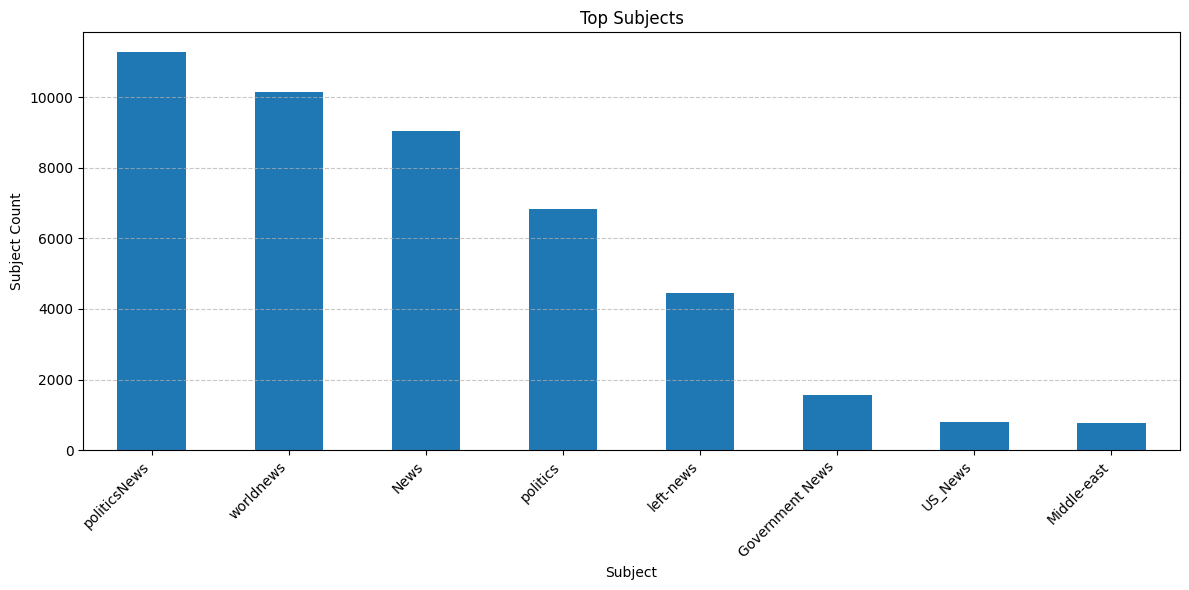

In [9]:
if 'subject' in df.columns:
    # Evaluates frequency of each value in 'subject' column
    subject_counts = df['subject'].value_counts()

    subject_counts.plot(kind='bar', figsize=(12, 6))
    plt.title("Top Subjects")
    plt.ylabel("Subject Count")
    plt.xlabel("Subject")

    plt.xticks(rotation=45, ha='right')

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

## Representations

In [10]:
# Count Vectorizer
count_vectorizer = CountVectorizer(stop_words="english", max_features=5000)
X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words="english", max_df=0.7, max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Tokenizer
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_tok = tokenizer.texts_to_sequences(X_train)
X_test_tok = tokenizer.texts_to_sequences(X_test)

# Pad sequences
maxlen = 200
X_train_tok = pad_sequences(X_train_tok, maxlen=maxlen)
X_test_tok = pad_sequences(X_test_tok, maxlen=maxlen)

# Function to extract statistical features
def extract_features(sequences):
    features = []
    for seq in sequences:
        nonzero = seq[seq > 0]  # Excluding padding
        if len(nonzero) == 0:
            avg = 0
            freq = 0
        else:
            avg = np.mean(nonzero)
            freq = len(nonzero)
        features.append([avg, freq])
    return np.array(features)

X_train_stats = extract_features(X_train_tok)
X_test_stats = extract_features(X_test_tok)

## Confusion Matrix example

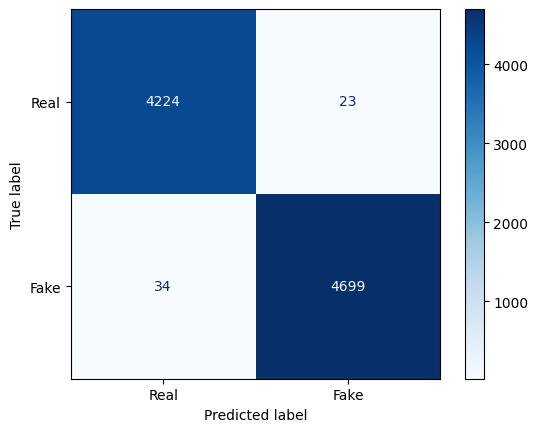

In [11]:
# Model training (SVM with TF-IDF vectorizer)
model = LinearSVC()
model.fit(X_train_tfidf, y_train)

# Prediction and evaluation
y_pred = model.predict(X_test_tfidf)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real', 'Fake'])
disp.plot(cmap='Blues')

## Helper function to evaluate models

In [12]:
results = []

def evaluate_and_store(model, model_name, rep_name, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append({
        "Model": model_name,
        "Representation": rep_name,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1
    })

## Train and Evaluate Models

In [13]:
# Naive Bayes
evaluate_and_store(MultinomialNB(), "Naive Bayes", "Count", X_train_count, X_test_count, y_train, y_test)
evaluate_and_store(MultinomialNB(), "Naive Bayes", "TF-IDF", X_train_tfidf, X_test_tfidf, y_train, y_test)
evaluate_and_store(MultinomialNB(), "Naive Bayes", "TokenizerStats", X_train_stats, X_test_stats, y_train, y_test)

# Perceptron
evaluate_and_store(Perceptron(max_iter=1000), "Perceptron", "Count", X_train_count, X_test_count, y_train, y_test)
evaluate_and_store(Perceptron(max_iter=1000), "Perceptron", "TF-IDF", X_train_tfidf, X_test_tfidf, y_train, y_test)
evaluate_and_store(Perceptron(max_iter=1000), "Perceptron", "TokenizerStats", X_train_stats, X_test_stats, y_train, y_test)

# Random Forest
evaluate_and_store(RandomForestClassifier(n_estimators=100, random_state=42),
                   "Random Forest", "Count", X_train_count, X_test_count, y_train, y_test)
evaluate_and_store(RandomForestClassifier(n_estimators=100, random_state=42),
                   "Random Forest", "TF-IDF", X_train_tfidf, X_test_tfidf, y_train, y_test)
evaluate_and_store(RandomForestClassifier(n_estimators=100, random_state=42),
                   "Random Forest", "TokenizerStats", X_train_stats, X_test_stats, y_train, y_test)

# SVM (Support Vector Machine)
evaluate_and_store(LinearSVC(), "SVM", "Count", X_train_count, X_test_count, y_train, y_test)
evaluate_and_store(LinearSVC(), "SVM", "TF-IDF", X_train_tfidf, X_test_tfidf, y_train, y_test)
evaluate_and_store(LinearSVC(), "SVM", "TokenizerStats", X_train_stats, X_test_stats, y_train, y_test)

# Table results

In [14]:
df_results = pd.DataFrame(results)
display(df_results)

,Model,Representation,Precision,Recall,F1-score
0,Naive Bayes,Count,0.942851,0.944644,0.943747
1,Naive Bayes,TF-IDF,0.917376,0.933657,0.925445
2,Naive Bayes,TokenizerStats,0.551599,0.706951,0.619687
3,Perceptron,Count,0.996180,0.991760,0.993965
4,Perceptron,TF-IDF,0.989438,0.989647,0.989543
5,Perceptron,TokenizerStats,0.543896,0.837735,0.659569
6,Random Forest,Count,0.998519,0.996831,0.997674
7,Random Forest,TF-IDF,0.997674,0.996831,0.997252
8,Random Forest,TokenizerStats,0.664706,0.716248,0.689515
9,SVM,Count,0.995981,0.994929,0.995455


## Standard evaluation

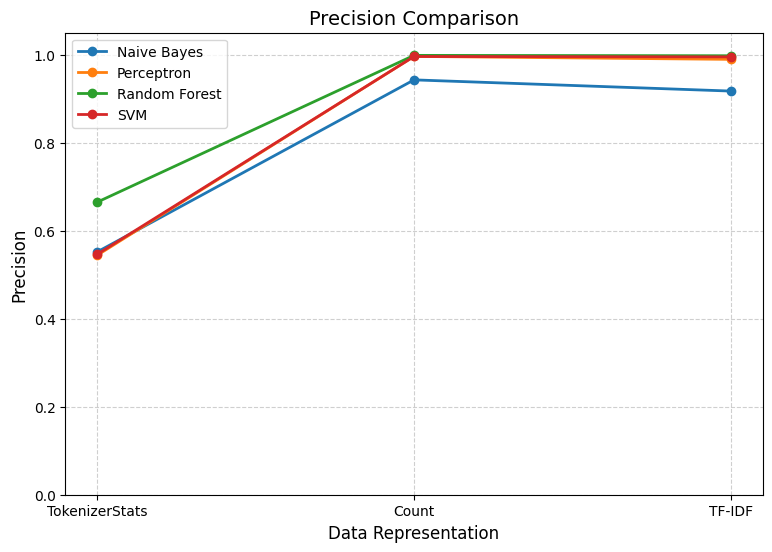

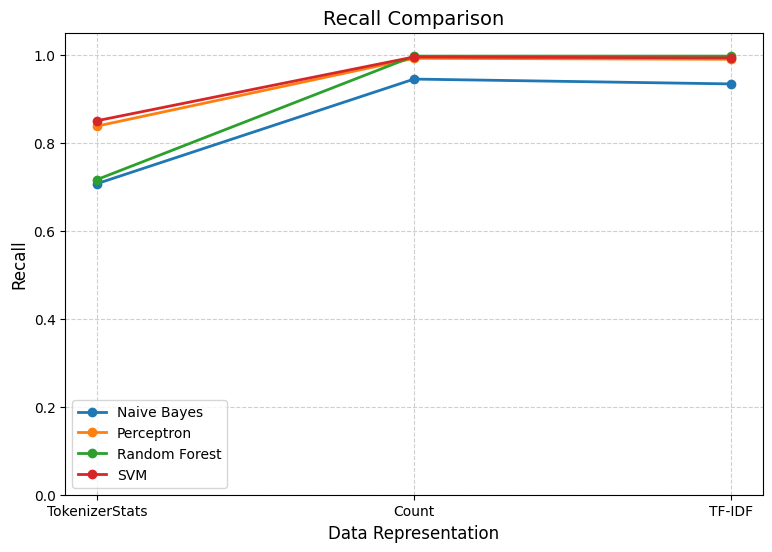

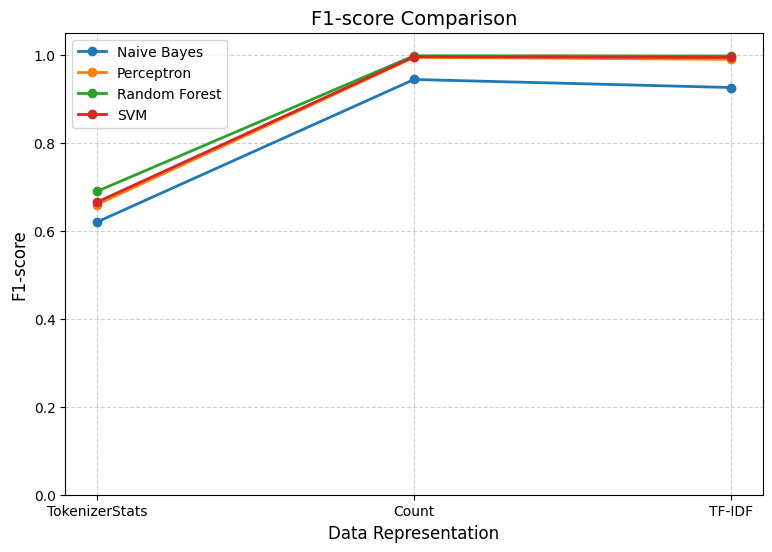

In [15]:
# Representations
representations = ["TokenizerStats", "Count", "TF-IDF"]

# Function to do a single plot for each metric
def plot_metric(metric_name):
    plt.figure(figsize=(9,6))

    # Naive Bayes
    subset_nb = df_results[df_results["Model"].str.contains("Naive Bayes")].copy()
    subset_nb["Rep"] = ["Count", "TF-IDF", "TokenizerStats"]
    subset_nb = subset_nb.set_index("Rep").loc[representations]
    plt.plot(representations, subset_nb[metric_name], marker="o", linewidth=2, label="Naive Bayes")

    # Perceptron
    subset_perc = df_results[df_results["Model"].str.contains("Perceptron")].copy()
    subset_perc["Rep"] = ["Count", "TF-IDF", "TokenizerStats"]
    subset_perc = subset_perc.set_index("Rep").loc[representations]
    plt.plot(representations, subset_perc[metric_name], marker="o", linewidth=2, label="Perceptron")

    # Random Forest
    subset_rf = df_results[df_results["Model"].str.contains("Random Forest")].copy()
    subset_rf["Rep"] = ["Count", "TF-IDF", "TokenizerStats"]
    subset_rf = subset_rf.set_index("Rep").loc[representations]
    plt.plot(representations, subset_rf[metric_name], marker="o", linewidth=2, label="Random Forest")

    # SVM
    subset_rf = df_results[df_results["Model"].str.contains("SVM")].copy()
    subset_rf["Rep"] = ["Count", "TF-IDF", "TokenizerStats"]
    subset_rf = subset_rf.set_index("Rep").loc[representations]
    plt.plot(representations, subset_rf[metric_name], marker="o", linewidth=2, label="SVM")

    plt.title(f"{metric_name} Comparison", fontsize=14)
    plt.ylim(0.0, 1.05)
    plt.xlabel("Data Representation", fontsize=12)
    plt.ylabel(metric_name, fontsize=12)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

# Separated plots
plot_metric("Precision")
plot_metric("Recall")
plot_metric("F1-score")

## K-Fold Cross Validation computation

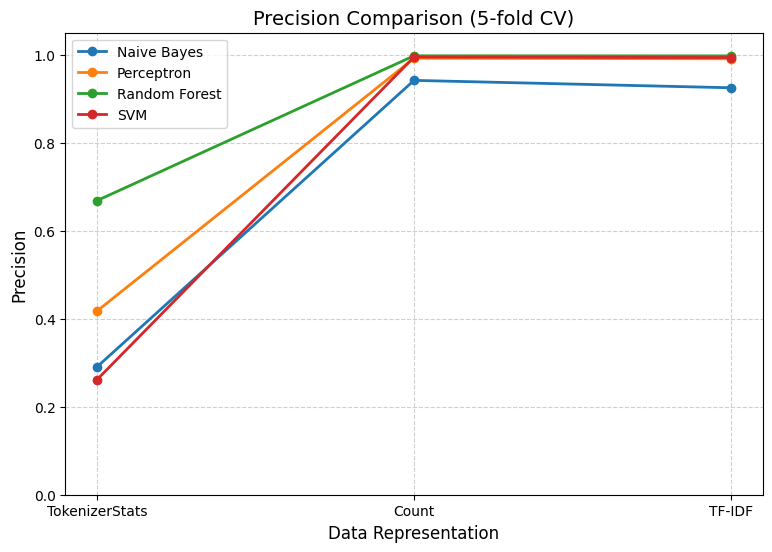

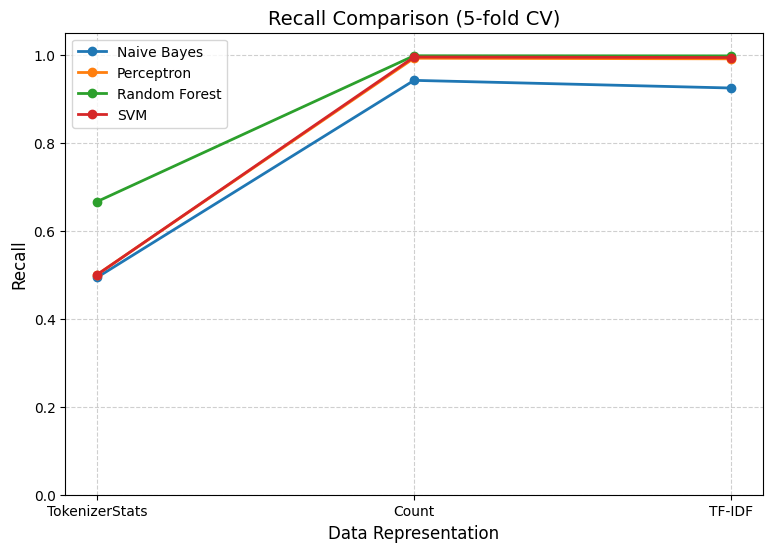

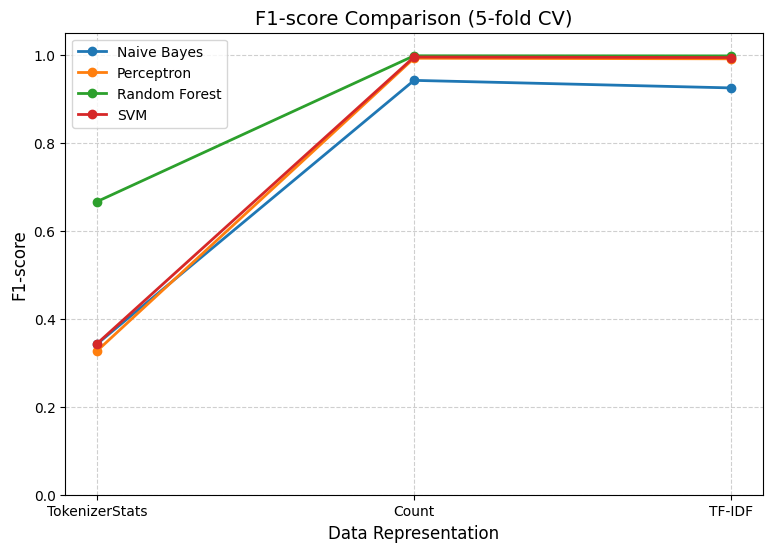

In [25]:
# Taking dataset
X_text = df["content"].values
y = df["label"].values

# CountVectorizer
count_vectorizer = CountVectorizer(stop_words="english", max_features=5000)
X_count = count_vectorizer.fit_transform(X_text)

# TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(X_text)

# TokenizerStats (average lenght words)
X_stats = df["content"].apply(lambda x: [len(x.split()), np.mean([len(w) for w in x.split()]) if len(x.split())>0 else 0])
X_stats = np.array(list(X_stats))

# K-Fold setup
N_SPLITS = 5
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

def cross_validate_model(model, X, y, model_name, rep_name):
    precisions, recalls, f1s = [], [], []

    for train_idx, test_idx in kf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        precisions.append(report["macro avg"]["precision"])
        recalls.append(report["macro avg"]["recall"])
        f1s.append(report["macro avg"]["f1-score"])

    return {
        "Model": model_name,
        "Representation": rep_name,
        "Precision": np.mean(precisions),
        "Recall": np.mean(recalls),
        "F1-score": np.mean(f1s)
    }

# Models list
models = [
    (MultinomialNB(), "Naive Bayes"),
    (Perceptron(max_iter=1000), "Perceptron"),
    (RandomForestClassifier(n_estimators=100, random_state=42), "Random Forest"),
    (LinearSVC(), "SVM")
]

# Representations list
representations = [
    (X_count, "Count"),
    (X_tfidf, "TF-IDF"),
    (X_stats, "TokenizerStats")
]

# Cross-validation computation
results = []
for model, model_name in models:
    for X_rep, rep_name in representations:
        res = cross_validate_model(model, X_rep, y, model_name, rep_name)
        results.append(res)


# Plots
order = ["TokenizerStats", "Count", "TF-IDF"]

def plot_metric(metric_name):
    plt.figure(figsize=(9,6))

    for model_name in df_results_cv["Model"].unique():
        subset = df_results_cv[df_results_cv["Model"] == model_name].set_index("Representation").loc[order]
        plt.plot(order, subset[metric_name], marker="o", linewidth=2, label=model_name)

    plt.title(f"{metric_name} Comparison (5-fold CV)", fontsize=14)
    plt.ylim(0.0, 1.05)
    plt.xlabel("Data Representation", fontsize=12)
    plt.ylabel(metric_name, fontsize=12)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

df_results_cv = pd.DataFrame(results)

# Separated plots
plot_metric("Precision")
plot_metric("Recall")
plot_metric("F1-score")

## Showing table results

In [26]:
display(df_results_cv)

,Model,Representation,Precision,Recall,F1-score
0,Naive Bayes,Count,0.941678,0.941733,0.941700
1,Naive Bayes,TF-IDF,0.924880,0.924353,0.924575
2,Naive Bayes,TokenizerStats,0.290517,0.493690,0.342432
3,Perceptron,Count,0.991997,0.992024,0.992009
4,Perceptron,TF-IDF,0.990750,0.990680,0.990713
5,Perceptron,TokenizerStats,0.417443,0.500106,0.326703
6,Random Forest,Count,0.997543,0.997638,0.997590
7,Random Forest,TF-IDF,0.997315,0.997373,0.997344
8,Random Forest,TokenizerStats,0.668390,0.666096,0.666143
9,SVM,Count,0.994735,0.994728,0.994732
